# Delta data time series analysis

A project in course "Algorithmics" (MTAT.03.238).

Team members: Kairit Peekman, Anisa Bruçi, Kaire Koljal


In [60]:
import math
import numpy as np
import sys
import time
import pandas as pd
import matplotlib.pyplot as plt
import random
import graphviz
from graphviz import Digraph
import sympy
from collections import defaultdict
import heapq
from os import walk
from datetime import datetime
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [61]:
# might be necessary for DTW
#!pip install dtw-python

from dtw import *

We had 33 files with data with total size of 570 MB.

There were 41 different devices that measured different things (temperature, electric power, heat energy, water, connection).
Delta has in total 182 time series. The 33 files contained 80 of them.

We focused on heat energy and electric power consuption as well as energy production. We tried to find correlations beteween them as well as with outside temperature.

There were 4 specific datasets we analysed:
1. Electric power produced in a day
2. Electric power consumed in a day
3. Heating (radiators, vents, floor)
4. Outside temperature


We wanted to see:

1. How is energy produced by solar panels in correlation with light
2. If consumed electrical power is related to temperature or is there a different kind of pattern
3. How heating is in correlation with temperature
4. How much of the energy produced at Delta cover the consumed energy

When we were processing data we had to:

1. Divide data into periods (7 AM to 7 PM is day, 7 PM to 7AM is night)
2. Put the data together from multiple files
3. Fill in the missing data (for heat, temperature and light, mean was used)
4. Normalize the data to make them comparable on one graph


## Our data

In [62]:
def readin(filename):
    path = "../DeltaDataAlgo/datafiles/"
    return pd.read_csv(path + filename)

In [63]:
_, _, filenames = next(walk("../DeltaDataAlgo/datafiles/"))

In [64]:
# Reads in all 33 data files, key is the filename
data = {}
for el in filenames:
    data[el] = readin(el)

In [65]:
devices = pd.read_csv("../DeltaDataAlgo/devices.csv")

In [66]:
times = pd.read_csv("../DeltaDataAlgo/DeviceTimeseries.csv")

In [67]:
deviceIDs = {}
dvs = []
for el in filenames:
    deviceIDs[el] = data[el].host.unique()
    dvs += data[el].host.unique().tolist()
dvs = list(set(dvs))

In [68]:
we = []
for el in filenames:
    we += times[(times["Device_id"].isin(deviceIDs[el])) & (times["measurement"] == el.replace(".csv",""))].values.tolist()

In [69]:
we = pd.DataFrame(we, columns = ['Device_id', 'device_label', 'measurement', 'measurement_description',
       'unit'])

In [70]:
stat = []
col = ["filename", "deviceId", "start", "end", "timepoints", "device_label", "description", "unit"]
row = []
for el in filenames:
    fname = el
    dId = deviceIDs[el]
    df = data[el]
    for d in dId:
        devId = el
        t0 = df[df["host"] == d]["time"].iloc[0]
        t1 = df[df["host"] == d]["time"].iloc[-1]
        tpoints = len(df[df["host"] == d]["time"])
        start = datetime.fromtimestamp(int(str(t0)[:13])/1e3).strftime("%d.%m.%Y %X")
        end = datetime.fromtimestamp(int(str(t1)[:13])/1e3).strftime("%d.%m.%Y %X")
        label = times[(times["Device_id"] == d) & (times["measurement"] == el.replace(".csv",""))]["device_label"].values.tolist()
        des = times[(times["Device_id"] == d) & (times["measurement"] == el.replace(".csv",""))]["measurement_description"].values.tolist()
        unit = times[(times["Device_id"] == d) & (times["measurement"] == el.replace(".csv",""))]["unit"].values.tolist()
        row = [fname, d, start, end, tpoints]
        row += label
        row += des
        row += unit
        stat += [row]

In [71]:
pd.set_option('display.max_rows', None)
pd.DataFrame(stat, columns = col)

,filename,deviceId,start,end,timepoints,device_label,description,unit
0,AktEN.csv,13318,22.09.2020 11:17:45,23.11.2020 15:37:34,208580,AK41'PaPaneel,Aktiivenergia välja,kilowatts
1,CO2.csv,13318,22.09.2020 11:17:47,23.11.2020 15:27:22,51565,AK41'PaPaneel,Kokkuhoitud CO2,kilograms
2,CumEg1.csv,3471282,22.09.2020 11:42:25,23.11.2020 15:56:32,1182,AK01'Mbus'Sooarv'Mtr204,Koguenergia - Jahutusarvesti,kilowattHours
3,CumEg1.csv,3471259,22.09.2020 13:03:18,23.11.2020 14:32:30,715,AK01'Mbus'Sooarv'Mtr200,Koguenergia - Sooja vee tootmine (Ruum 0013),kilowattHours
4,CumEg1.csv,3471260,22.09.2020 13:03:20,23.11.2020 14:32:32,704,AK01'Mbus'Sooarv'Mtr201,Koguenergia - Radiaatoriküte (Ruum 0013),kilowattHours
5,CumEg1.csv,3471261,22.09.2020 15:05:32,23.11.2020 14:32:34,635,AK01'Mbus'Sooarv'Mtr202,Koguenergia - Vent. küte (Ruum 0013),kilowattHours
6,CumEg1.csv,3471262,22.09.2020 15:05:33,23.11.2020 14:32:35,682,AK01'Mbus'Sooarv'Mtr203,Koguenergia - Põrandaküte (Ruum 0013),kilowattHours
7,DCall.csv,13318,22.09.2020 11:17:47,23.11.2020 15:52:15,106364,AK41'PaPaneel,DC voolutugevus,amperes
8,EelKuu4.csv,11030,28.09.2020 15:20:56,10.11.2020 09:22:07,5,AK05'VorAn'VorAn2,Eelmise kuu tarbimine PJK sekt. 2 - Kogu ekspo...,kilowattHours
9,EelKuu5.csv,11029,23.09.2020 00:00:04,23.11.2020 00:00:04,87,AK05'VorAn'VorAn1,PJK sekt. 1 - Eelmise päeva imporditud aktiive...,kilowattHours


## 1. General functions

In [72]:
# function for smoothing the data; returns a list of values
# from: https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775
def smoothing(values, alpha):
    final = [values[0]]
    for n in range(1, len(values)):
        final.append(alpha * values[n] + (1 - alpha) * final[n-1])
    return final

## 2. Temperature data

In [75]:
temp = data["TE00.csv"].copy()
temp["time"] = pd.to_datetime(temp["time"],errors='coerce')
temp = temp.sort_values(by=["time"])
temp.set_index(temp["time"])
temp = temp.resample("12H", origin="07:00:00.000", on="time").mean()
temp = temp.interpolate(method='time')
temp.value =(temp.value-temp.value.mean())/temp.value.std()
temp = temp[4:-5]
temp["tm"] = temp.index

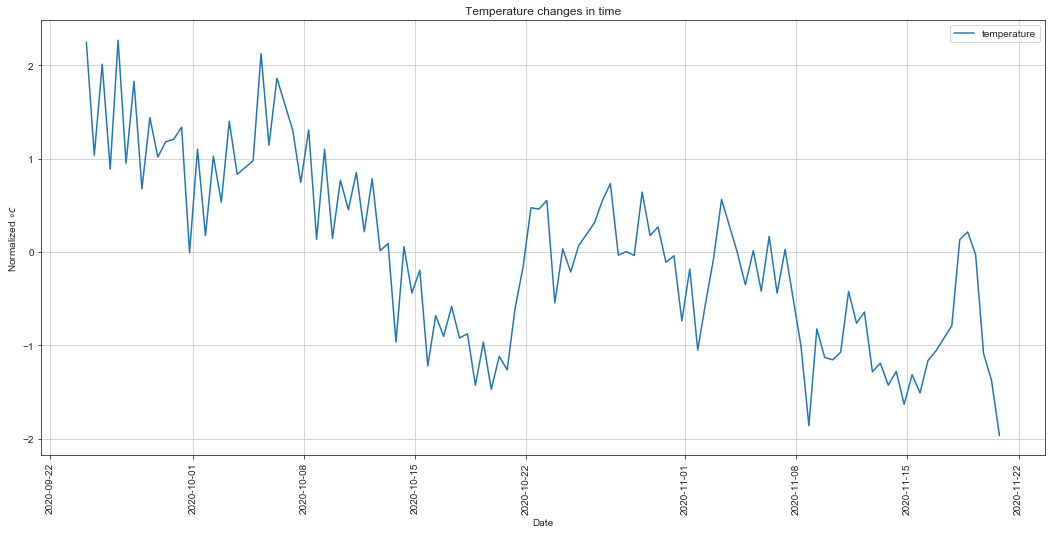

In [76]:
#sns.set_style("darkgrid")
plt.figure(figsize=(18,8))
sns.lineplot(data=temp, x='time', y='value', label="temperature")
plt.xticks(rotation=90)
plt.title("Temperature changes in time")
plt.xlabel("Date")
plt.ylabel("Normalized $ \circ c$")
plt.grid(True);
plt.show()


In [78]:
temp_smooth = smoothing(temp.value, 0.05)

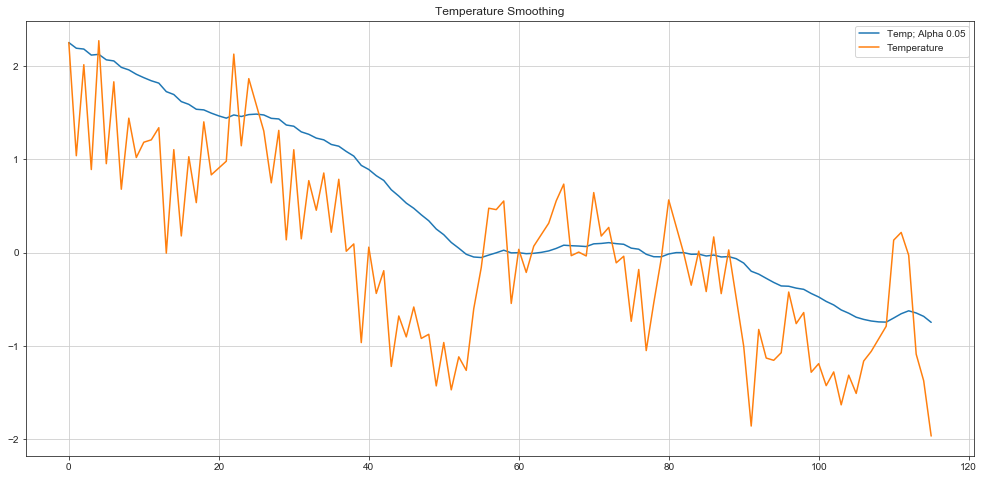

In [79]:
# temperature normalized vs smooth

# smooth temp with original
plt.figure(figsize=(17, 8))
plt.plot(temp_smooth, label="Temp; Alpha 0.05")
plt.plot(temp.value.values, label = "Temperature")
plt.legend(loc="best")
plt.axis('tight')
plt.title("Temperature Smoothing")
plt.grid(True);

## 3. Light level

In [80]:
lux = data["Lux.csv"].copy()
lux["time"] = pd.to_datetime(lux["time"],errors='coerce')
lux = lux.sort_values(by=["time"])
lux.set_index(lux["time"])
lux = lux.resample("12H", origin="07:00:00.000", on="time").mean()
lux = lux.interpolate(method='time')
lux.value = (lux.value-lux.value.mean())/lux.value.std()
lux = lux[4:-5]
lux["tm"] = lux.index

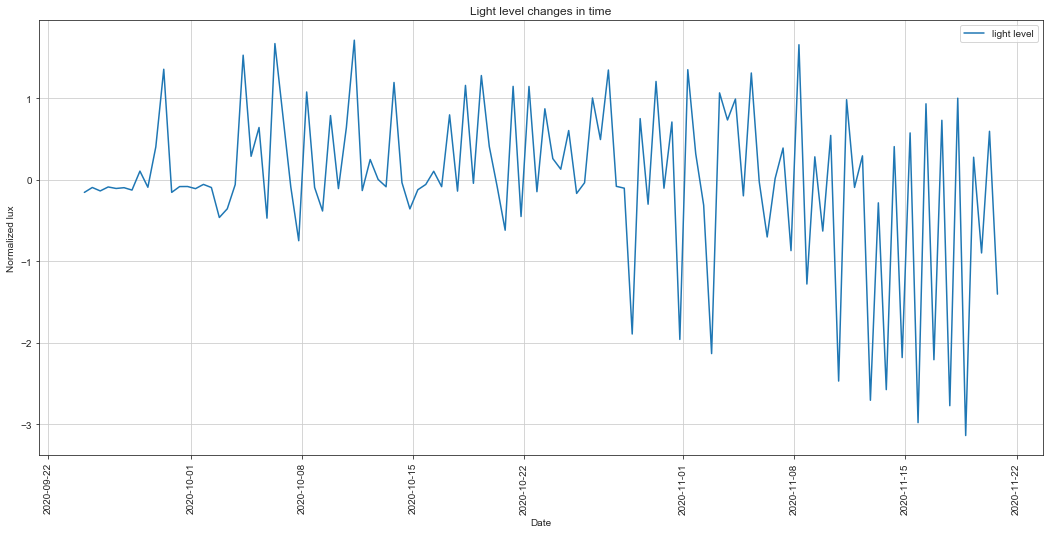

In [81]:
#sns.set_style("darkgrid")
plt.figure(figsize=(18,8))
sns.lineplot(data=lux, x='time', y='value', label="light level")
plt.xticks(rotation=90)
plt.title("Light level changes in time")
plt.xlabel("Date")
plt.ylabel("Normalized lux")
plt.grid(True);
plt.show()

In [83]:
lux_smooth = smoothing(lux.value, 0.05)

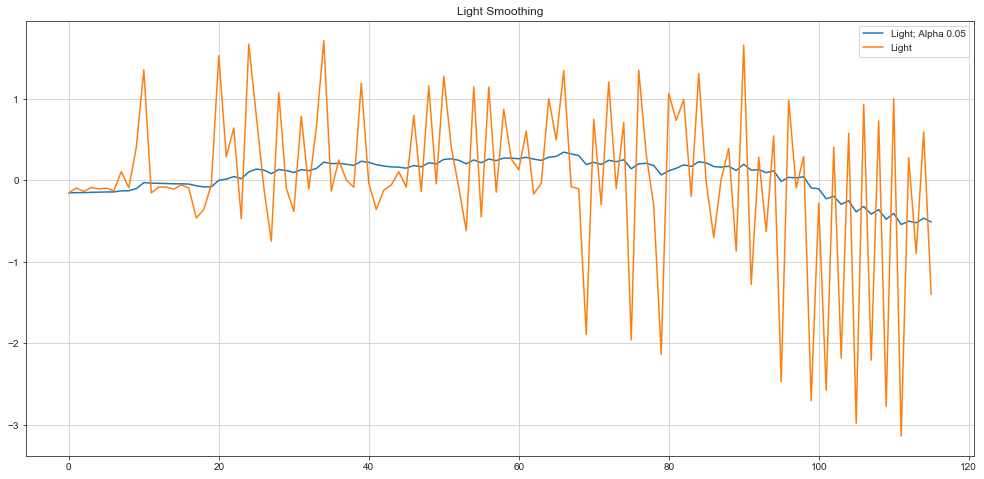

In [84]:
# smooth light with original
plt.figure(figsize=(17, 8))
plt.plot(lux_smooth, label="Light; Alpha 0.05")
plt.plot(lux.value.values, label = "Light")
plt.legend(loc="best")
plt.axis('tight')
plt.title("Light Smoothing")
plt.grid(True);

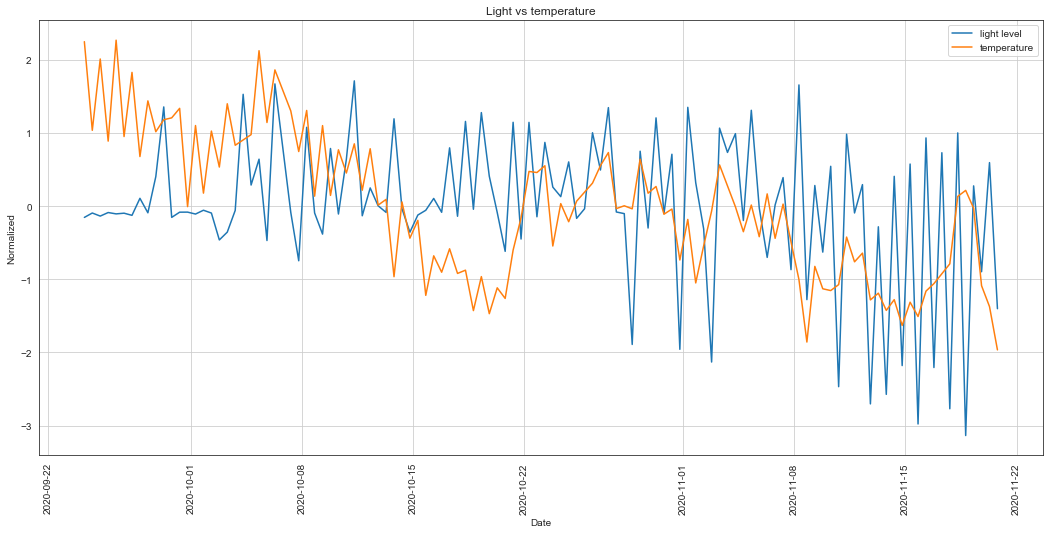

In [221]:
# Light and temperature

#sns.set_style("darkgrid")
plt.figure(figsize=(18,8))
sns.lineplot(data=lux, x='time', y='value', label="light level")
sns.lineplot(data=temp, x='time', y='value', label="temperature")
plt.xticks(rotation=90)
plt.title("Light vs temperature")
plt.xlabel("Date")
plt.ylabel("Normalized")
plt.grid(True)
plt.show()

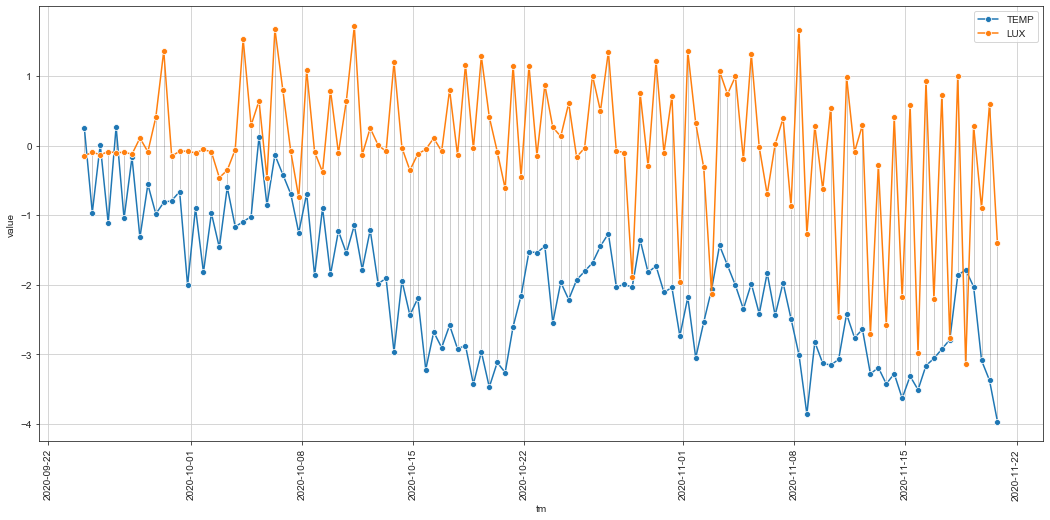

In [227]:
sns.set_style("ticks")
xshift = 0
yshift = 2
start = 0
interval = 1
plt.figure(figsize=(18,8))
sns.lineplot(x=temp["tm"], y=temp["value"]-yshift, marker='o',label = "TEMP")
sns.lineplot(x=pd.DatetimeIndex(lux.tm) + pd.DateOffset(xshift), y=lux['value'], marker='o', label = "LUX")

for i in range(start,len(temp),interval):
    sns.lineplot(x = [temp.iloc[i, 3],lux.iloc[i, 3] + pd.DateOffset(xshift)], y = [temp.iloc[i, 2]-yshift,lux.iloc[i, 2]], color='black', linewidth=0.5)
     
plt.xticks(rotation=90)
#plt.title("...")
#plt.xlabel("...")
#plt.ylabel("...")
plt.legend()
plt.grid(True)
plt.show()

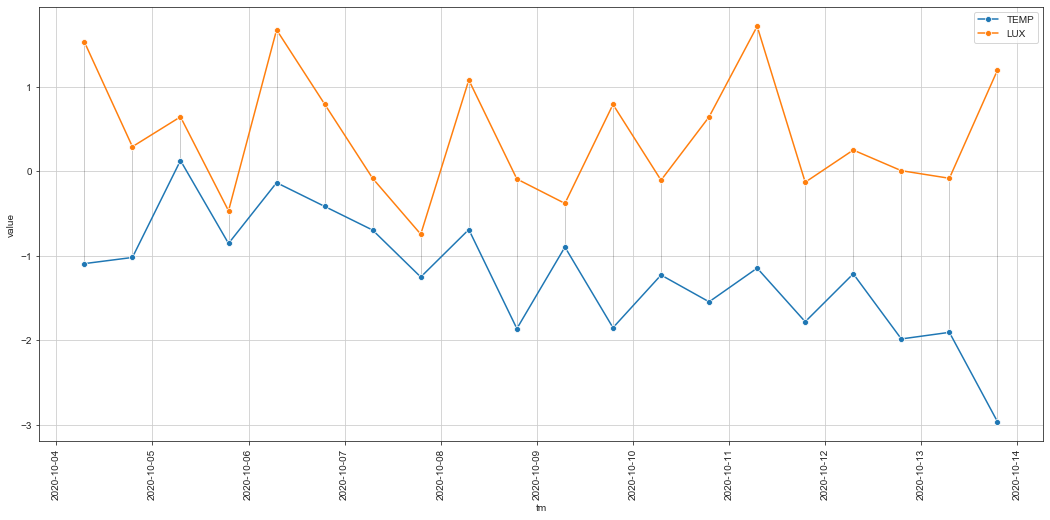

In [228]:
tempv = temp.copy()
tempv = tempv[20:40]
luxv = lux.copy()
luxv = luxv[20:40]

sns.set_style("ticks")
xshift = 0
yshift = 2
start = 0
interval = 1
plt.figure(figsize=(18,8))
sns.lineplot(x=tempv["tm"], y=tempv["value"]-yshift, marker='o',label = "TEMP")
sns.lineplot(x=pd.DatetimeIndex(luxv.tm) + pd.DateOffset(xshift), y=luxv['value'], marker='o', label = "LUX")

for i in range(start,len(tempv),interval):
    sns.lineplot(x = [tempv.iloc[i, 3],luxv.iloc[i, 3] + pd.DateOffset(xshift)], y = [tempv.iloc[i, 2]-yshift,luxv.iloc[i, 2]], color='black', linewidth=0.5)
     
plt.xticks(rotation=90)
#plt.title("...")
#plt.xlabel("...")
#plt.ylabel("...")
plt.legend()
plt.grid(True)
plt.show()

## 4. Heating

In [102]:
kytefiledata = data["CumEg1.csv"]
hosts = [3471260, 3471261, 3471262 ]
kytedata = kytefiledata[kytefiledata["host"].isin(hosts)]

radikas =  kytedata[kytedata["host"] == 3471260]
vent =  kytedata[kytedata["host"] == 3471261]
porand =  kytedata[kytedata["host"] == 3471262]

radikas["time"] = pd.to_datetime(radikas["time"])
vent["time"] = pd.to_datetime(vent["time"])
porand["time"] = pd.to_datetime(porand["time"])

radikas = radikas.drop_duplicates(subset=["value"])
vent = vent.drop_duplicates(subset=["value"])
porand = porand.drop_duplicates(subset=["value"])

radikas = radikas[radikas.time < "2020-11-21 07:00:00"]
vent = vent[vent.time < "2020-11-21 07:00:00"]
porand = porand[porand.time < "2020-11-21 07:00:00"]

radikas = radikas[radikas.time > "2020-09-24 07:00:00"]
vent = vent[vent.time > "2020-09-24 07:00:00"]
porand = porand[porand.time > "2020-09-24 07:00:00"]

In [103]:
radikas = radikas.resample("12H", origin="2020-09-24 07:00:00.000", on="time").mean()
vent = vent.resample("12H", origin="2020-09-24 07:00:00.000", on="time").mean()
porand = porand.resample("12H", origin="2020-09-24 07:00:00.000", on="time").mean()

radikas = radikas.interpolate(method='time')
vent = vent.interpolate(method='time')
porand = porand.interpolate(method='time')

In [104]:
heatingdata = pd.DataFrame()
heatingdata = radikas["value"]

result1 = pd.concat([heatingdata, vent], axis=1)
result2 = result1.drop(['tags', 'host'], axis=1)
result3 = pd.concat([result2, porand], axis=1)

allheating = result3.drop(['tags', 'host'], axis=1)
allheating["sum"] = allheating.sum(axis=1)

totalheating = pd.DataFrame()
totalheating["value"] = allheating["sum"]
totalheating["tm"] = totalheating.index

In [105]:
#pd.set_option('display.max_rows', None)
#totalheating

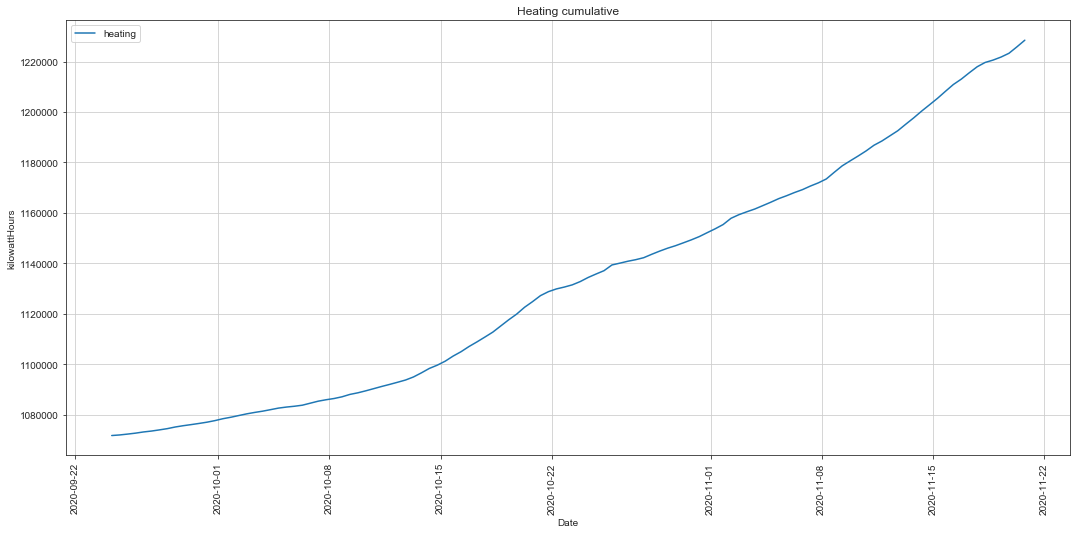

In [106]:
#sns.set_style("darkgrid")
plt.figure(figsize=(18,8))
sns.lineplot(data=totalheating, x='tm', y='value', label="heating")
plt.xticks(rotation=90)
plt.title("Heating cumulative")
plt.xlabel("Date")
plt.ylabel("kilowattHours")
plt.grid(True)
plt.show()

In [107]:
addedHeating = pd.DataFrame()
addedHeating= totalheating
addedHeating = addedHeating.diff(periods=1, axis=0)
addedHeating["tm"] = addedHeating.index

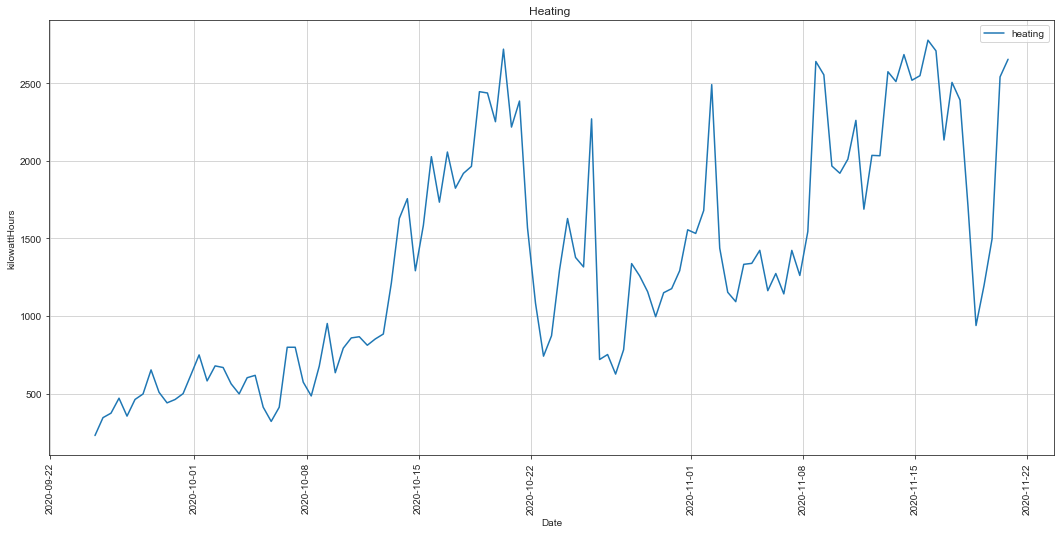

In [108]:
#sns.set_style("darkgrid")
plt.figure(figsize=(18,8))
sns.lineplot(data=addedHeating, x='tm', y='value', label="heating")
plt.xticks(rotation=90)
plt.title("Heating ")
plt.xlabel("Date")
plt.ylabel("kilowattHours")
plt.grid(True)
plt.show()

In [109]:
addedHeating.value = (addedHeating.value-addedHeating.value.mean())/addedHeating.value.std()


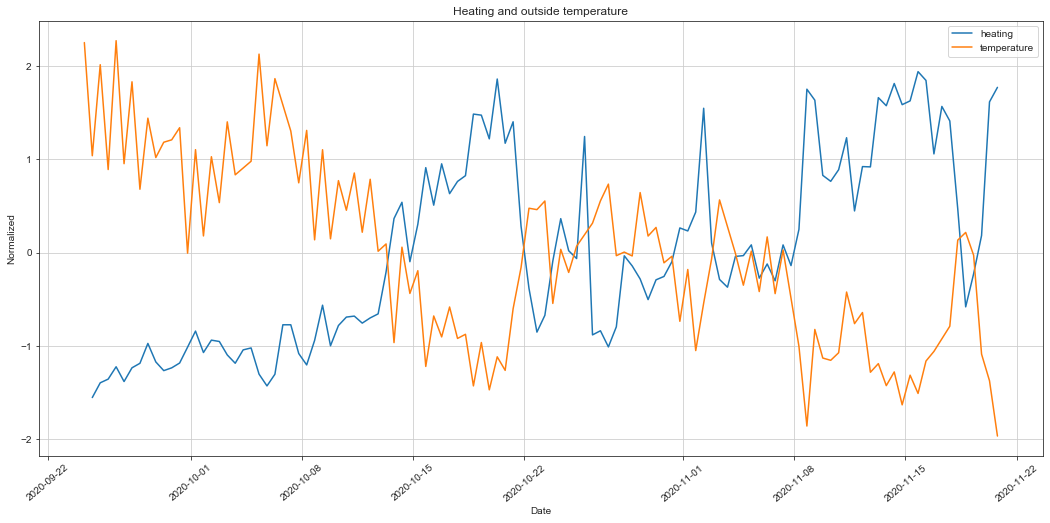

In [110]:
#sns.set_style("darkgrid")
plt.figure(figsize=(18,8))
sns.lineplot(data=addedHeating, x='tm', y='value', label="heating")
sns.lineplot(data=temp, x='time', y='value', label="temperature")
plt.xticks(rotation=40)
plt.title("Heating and outside temperature")
plt.xlabel("Date")
plt.ylabel("Normalized")
plt.grid(True)
plt.show()

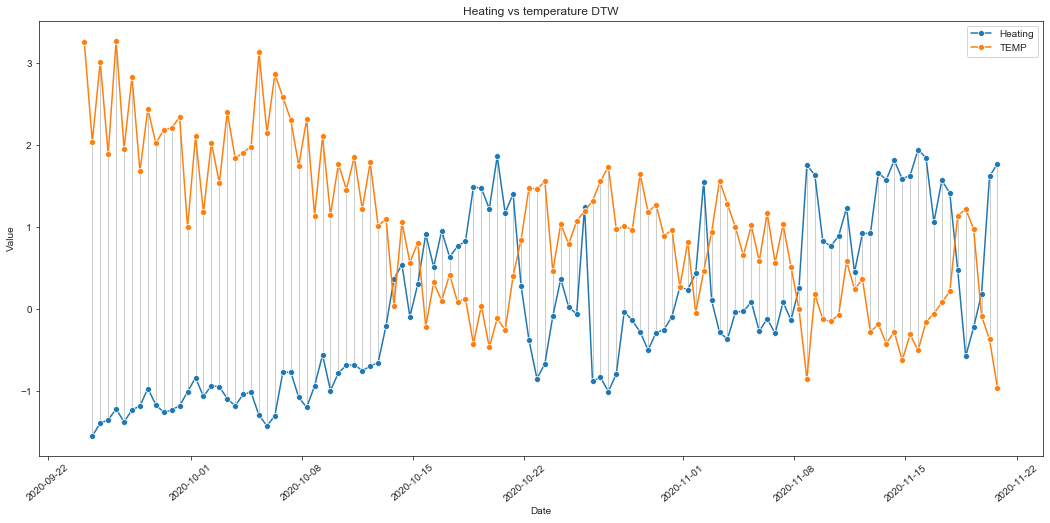

In [111]:
sns.set_style("ticks")
xshift = 0
yshift = -1
start = 0
interval = 1
plt.figure(figsize=(18,8))

sns.lineplot(x=pd.DatetimeIndex(addedHeating.tm) + pd.DateOffset(xshift), y=addedHeating['value'], marker='o', label = "Heating")
sns.lineplot(x=temp["tm"], y=temp["value"]-yshift, marker='o',label = "TEMP")

for i in range(start,len(temp),interval):
    sns.lineplot(x = [temp.iloc[i, 3],addedHeating.iloc[i, 1] + pd.DateOffset(xshift)], y = [temp.iloc[i, 2]-yshift,addedHeating.iloc[i, 0]], color='black', linewidth=0.5)
     
plt.xticks(rotation=40)
plt.title("Heating vs temperature DTW")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

In [112]:
heating_smooth = smoothing(addedHeating.value.iloc[1:], 0.05)

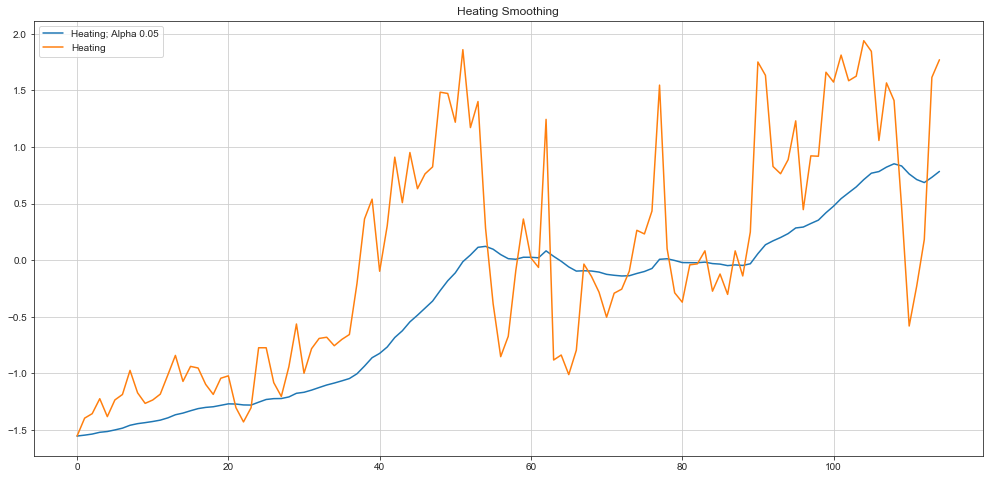

In [113]:
# smooth heating with original
plt.figure(figsize=(17, 8))
plt.plot(heating_smooth, label="Heating; Alpha 0.05")
plt.plot(addedHeating.value.iloc[1:].values, label = "Heating")
plt.legend(loc="best")
plt.axis('tight')
plt.title("Heating Smoothing")
plt.grid(True)

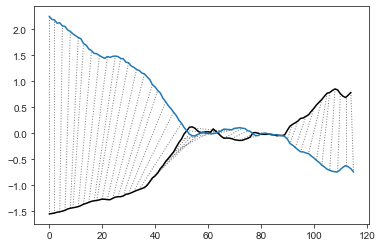

In [114]:
# DTW with installed tool; on smooth data

# documentation
# https://dynamictimewarping.github.io/py-api/html/api/dtw.dtw.html
# https://dynamictimewarping.github.io/

# blue line is temperature, black is heating

res = dtw(heating_smooth, temp_smooth, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway", xlab="Time", ylab="Value")

In [115]:
# necessary to make the heating list as long as temp
# first value was NaN in the table, it is replaced with the otherwise first value of the smooth values list
heat_smooth2 = [heating_smooth[0]] + heating_smooth

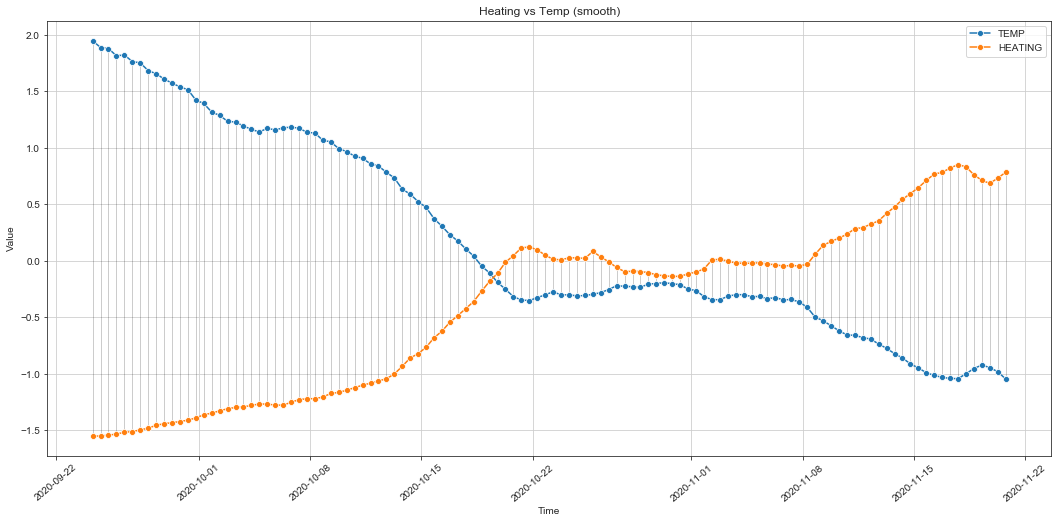

In [116]:
# DTW manually

sns.set_style("ticks")
xshift = 0
yshift = 0.3
start = 0
interval = 1
plt.figure(figsize=(18,8))

sns.lineplot(x=temp["tm"], y=[t- yshift for t in temp_smooth], marker='o',label = "TEMP")
sns.lineplot(x=pd.DatetimeIndex(addedHeating.tm) + pd.DateOffset(xshift), y=heat_smooth2, marker='o', label = "HEATING")

for i in range(start,len(temp),interval):
    sns.lineplot(x = [temp.iloc[i, 3],addedHeating.iloc[i, 1] + pd.DateOffset(xshift)], y = [temp_smooth[i]-yshift,heat_smooth2[i]], color='black', linewidth=0.5)
     
plt.xticks(rotation=40)
plt.title("Heating vs Temp (smooth)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


## 5. Electricity consumption (measure interval 24h)

In [117]:
tb = data["EelKuu5.csv"].copy()

In [118]:
tb29 = tb[tb.host == 11029]
tb29 = tb29.drop_duplicates(subset=['value'])
tb29["time"] = pd.to_datetime(tb29["time"],errors='coerce')
tb29.loc[116, ["time"]] = pd.to_datetime("2020-11-02 22:00:38.977")
#tb29["time"] =pd.DatetimeIndex(tb29.time) + pd.DateOffset(-1)
tb29.set_index(tb29["time"])
tb29["value"] = tb29["value"]/2
tb29 = tb29.resample("12H", origin="07:00:00.000", on="time").mean()
tb29 = tb29.backfill()
tb29 = tb29[5:-2]

In [119]:
tb30 = tb[tb.host == 11030]
tb30 = tb30.drop_duplicates(subset=['value'])
tb30["time"] = pd.to_datetime(tb30["time"],errors='coerce')
tb30.loc[117, ["time"]] = pd.to_datetime("2020-11-02 01:23:38.977")
#tb30["time"] =pd.DatetimeIndex(tb30.time) + pd.DateOffset(-1)
tb30.set_index(tb30["time"])
tb30["value"] = tb30["value"]/2
tb30 = tb30.resample("12H", origin="07:00:00.000", on="time").mean()
tb30 = tb30.backfill()
tb30 = tb30[5:-2]

In [120]:
tb2 = tb30.copy()
tb2.loc[:,"value"] += tb29["value"]
tb2.value=(tb2.value-tb2.value.mean())/tb2.value.std()
tb2["tm"] = tb2.index

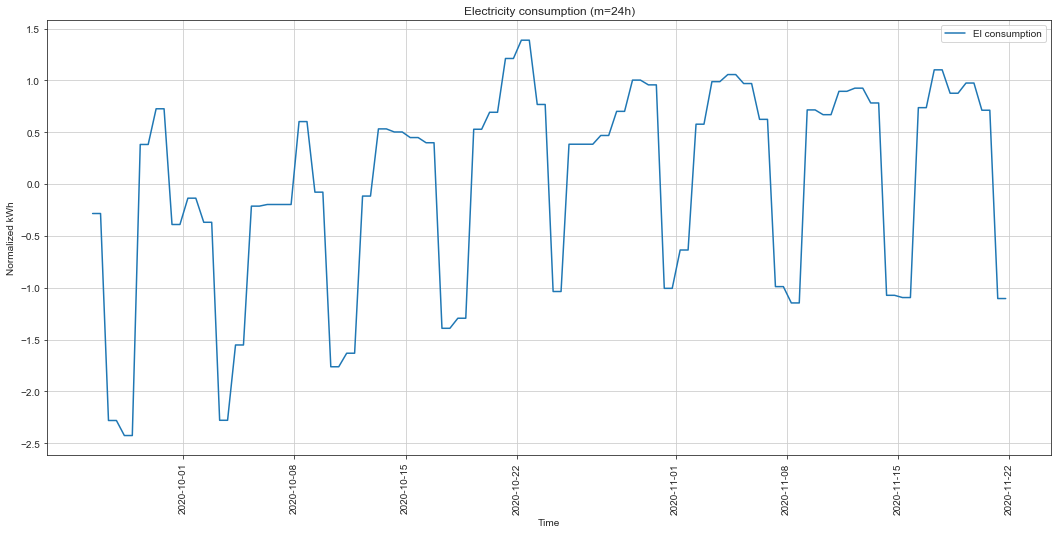

In [121]:
plt.figure(figsize=(18,8))
sns.lineplot(data=tb2, x='time', y='value', label = "El consumption")
plt.xticks(rotation=90)
plt.title("Electricity consumption (m=24h)")
plt.xlabel("Time")
plt.ylabel("Normalized kWh")
plt.legend()
plt.grid(True)
plt.show()

In [222]:
tb2_smooth = smoothing(tb2.value, 0.05)

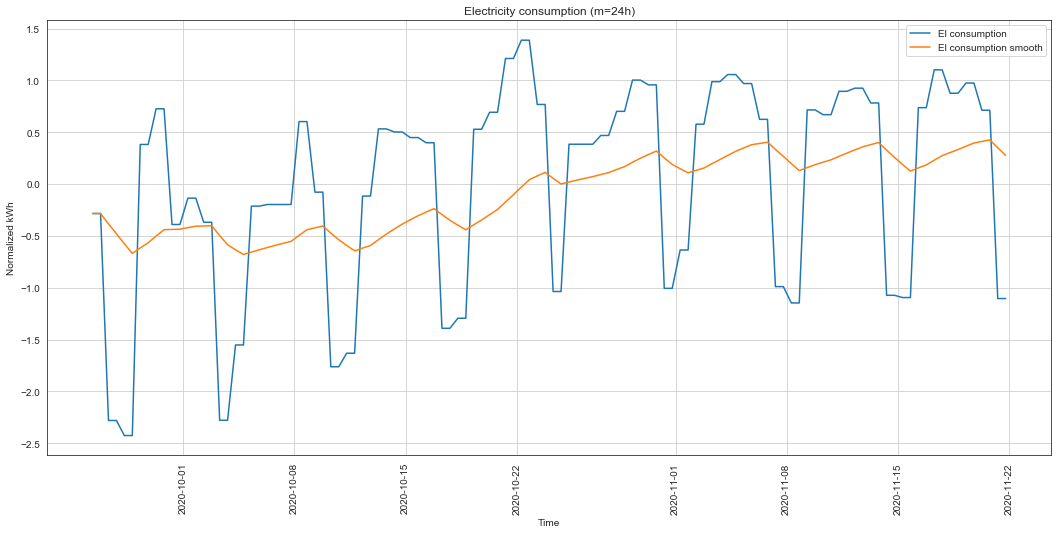

In [224]:
plt.figure(figsize=(18,8))
sns.lineplot(data=tb2, x='tm', y='value', label = "El consumption")
sns.lineplot(data=tb2, x='tm', y=tb2_smooth, label = "El consumption smooth")
plt.xticks(rotation=90)
plt.title("Electricity consumption (m=24h)")
plt.xlabel("Time")
plt.ylabel("Normalized kWh")
plt.legend()
plt.grid(True)
plt.show()

## 6. Electricity consumption (measure interval many times in day)

In [138]:
en = data["KogEn.csv"].copy()
en.loc[:125, "time"] = en.loc[:125, "time"] * 1000000
en["time"] = pd.to_datetime(en["time"],errors='coerce')
en = en.sort_values(by=["time"])

In [139]:
en29 = en[en.host == 11029]
en29 = en29.drop(125)
en29 = en29.drop_duplicates(subset=['value'])
a = en29["value"][1:].values
b = en29["value"][:-1].values
en29 = en29[1:]
en29.loc[:,"value"] = a - b
en29 = en29.resample("12H", origin="07:00:00.000", on="time").mean()
en29[en29.value == 0.0] = np.nan
en29 = en29.interpolate(method='time')
en29["2020-10-07 07:00:00":"2020-10-07 07:00:00"] = en29["2020-10-07 07:00:00":"2020-10-07 07:00:00"]/2

In [140]:
en30 = en[en.host == 11030]
en30 = en30.drop_duplicates(subset=['value'])
c = en30["value"][1:].values
d = en30["value"][:-1].values
en30 = en30[1:]
en30.loc[:,"value"] = c - d
en30 = en30.resample("12H", origin="07:00:00.000", on="time").mean()
en30[en30.value == 0.0] = np.nan
en30 = en30.interpolate(method='time')
en30["2020-10-07 07:00:00":"2020-10-07 07:00:00"] = en30["2020-10-07 07:00:00":"2020-10-07 07:00:00"]/2


In [141]:
en2 = en29.copy()
en2["value"] += en30["value"]
en2.value=(en2.value-en2.value.mean())/en2.value.std()
en2 = en2[4:-5]
en2["tm"] = en2.index

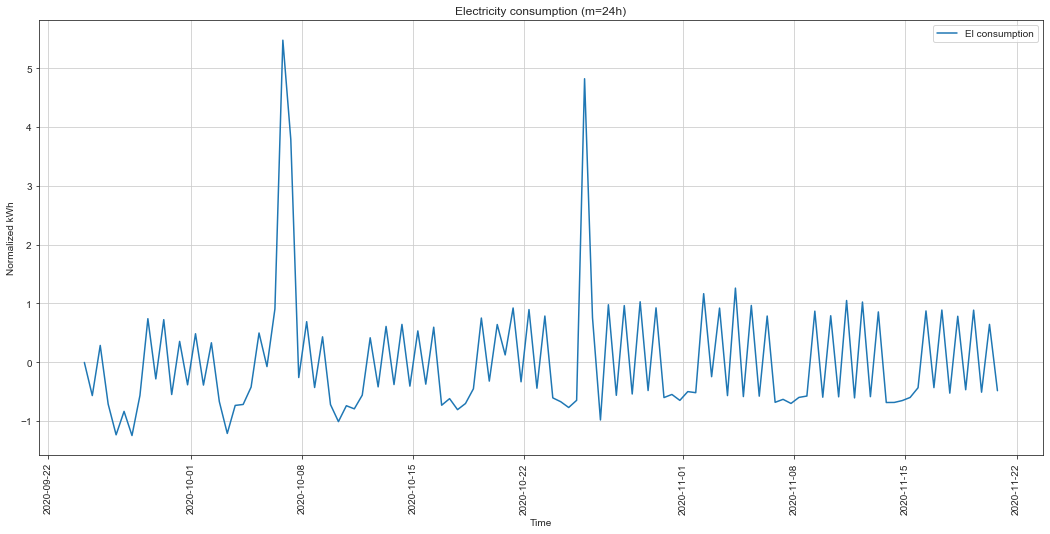

In [142]:
plt.figure(figsize=(18,8))
sns.lineplot(data=en2, x='time', y='value', label = "El consumption")
plt.xticks(rotation=90)
plt.title("Electricity consumption (m=24h)")
plt.xlabel("Time")
plt.ylabel("Normalized kWh")
plt.legend()
plt.grid(True)
plt.show()

In [214]:
en2_smooth = smoothing(en2.value, 0.05)

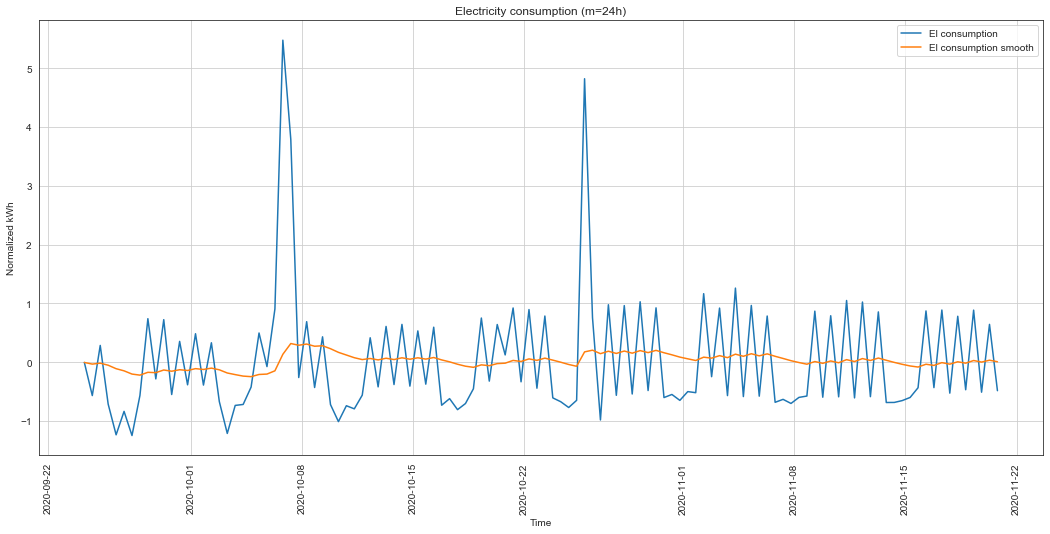

In [226]:
plt.figure(figsize=(18,8))
sns.lineplot(data=en2, x='tm', y='value', label = "El consumption")
sns.lineplot(data=en2, x='tm', y=en2_smooth, label = "El consumption smooth")
plt.xticks(rotation=90)
plt.title("Electricity consumption (m=24h)")
plt.xlabel("Time")
plt.ylabel("Normalized kWh")
plt.legend()
plt.grid(True)
plt.show()

### 2 different electritcity consumptions together

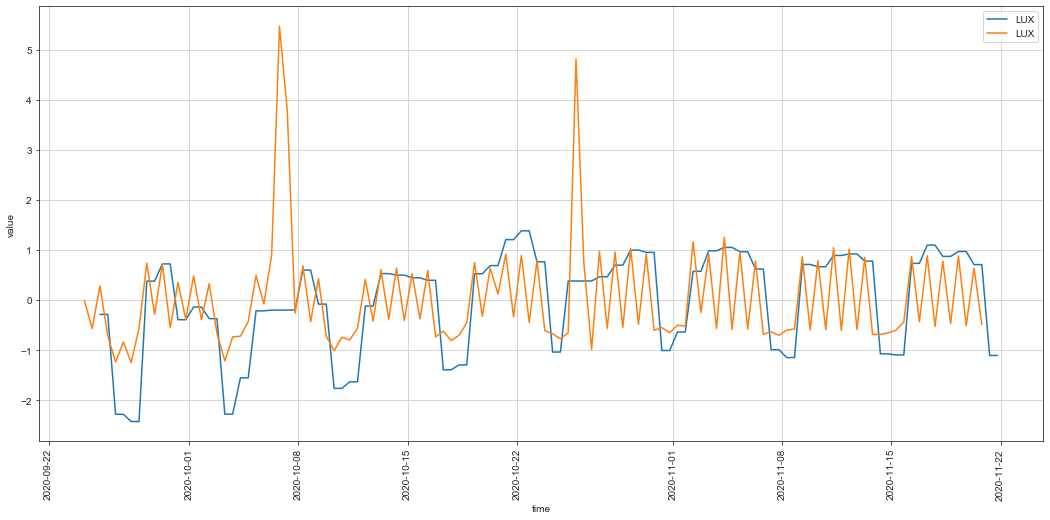

In [143]:
plt.figure(figsize=(18,8))
sns.lineplot(data=tb2, x='time', y='value', label = "LUX")
sns.lineplot(data=en2, x='time', y='value', label = "LUX")
plt.xticks(rotation=90)
#plt.title("...")
#plt.xlabel("...")
#plt.ylabel("...")
plt.legend()
plt.grid(True)
plt.show()

# 7. Electricity production

In [201]:
prod = data["PaevEN.csv"].copy()
prod = prod[190:]
prod["time"] = pd.to_datetime(prod["time"],errors='coerce')
prod = prod.sort_values(by=["time"])
prod = prod.resample("12H", origin="07:00:00.000", on="time").mean()
prod = prod.interpolate(method='linear')
prod.value=(prod.value-prod.value.mean())/prod.value.std()
prod = prod[4:-5]
prod["tm"] = prod.index

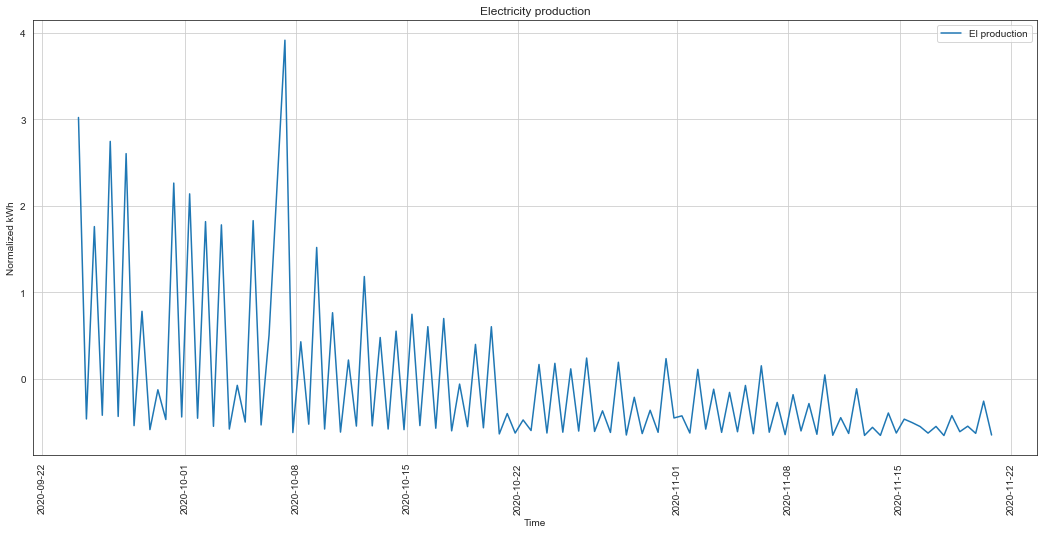

In [202]:
plt.figure(figsize=(18,8))
sns.lineplot(data=prod, x='time', y='value', label = "El production")
plt.xticks(rotation=90)
plt.title("Electricity production")
plt.xlabel("Time")
plt.ylabel("Normalized kWh")
plt.legend()
plt.grid(True)
plt.show()

In [203]:
prod_smooth = smoothing(prod.value, 0.05)

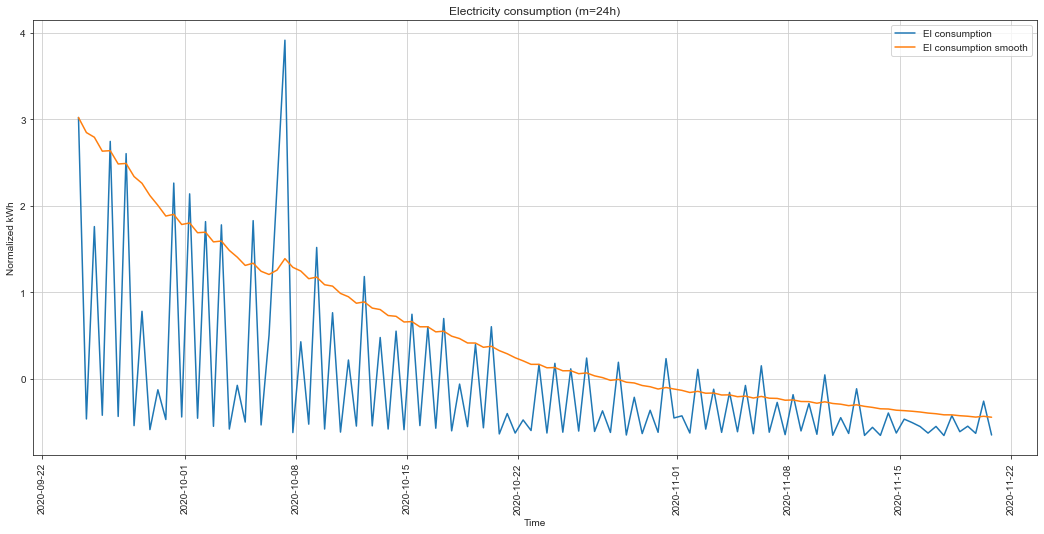

In [230]:
plt.figure(figsize=(18,8))
sns.lineplot(data=prod, x='tm', y='value', label = "El consumption")
sns.lineplot(data=prod, x='tm', y=prod_smooth, label = "El consumption smooth")
plt.xticks(rotation=90)
plt.title("Electricity consumption (m=24h)")
plt.xlabel("Time")
plt.ylabel("Normalized kWh")
plt.legend()
plt.grid(True)
plt.show()

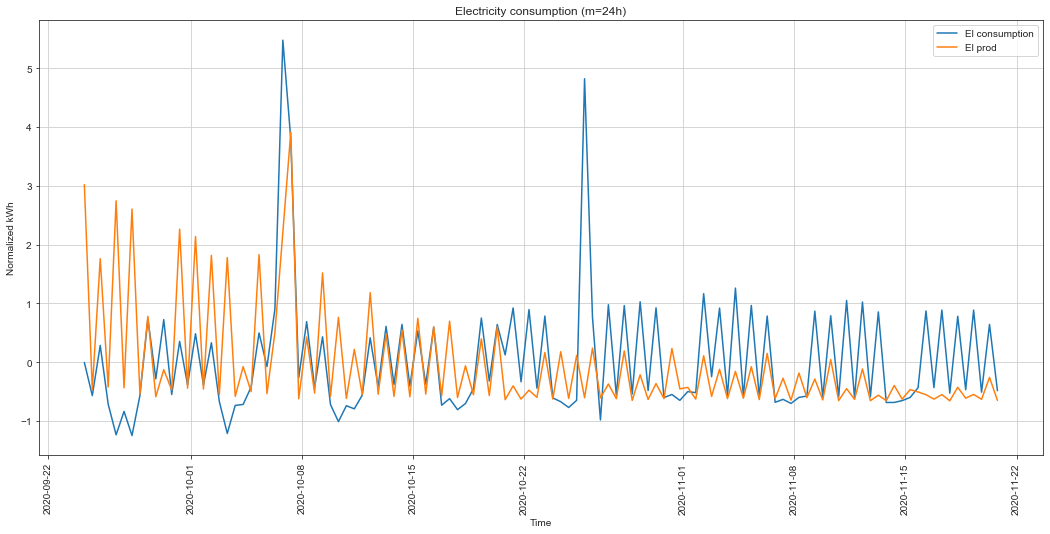

In [234]:
plt.figure(figsize=(18,8))
sns.lineplot(data=en2, x='tm', y='value', label = "El consumption")
sns.lineplot(data=prod, x='tm', y='value', label = "El prod")
plt.xticks(rotation=90)
plt.title("Electricity consumption (m=24h)")
plt.xlabel("Time")
plt.ylabel("Normalized kWh")
plt.legend()
plt.grid(True)
plt.show()

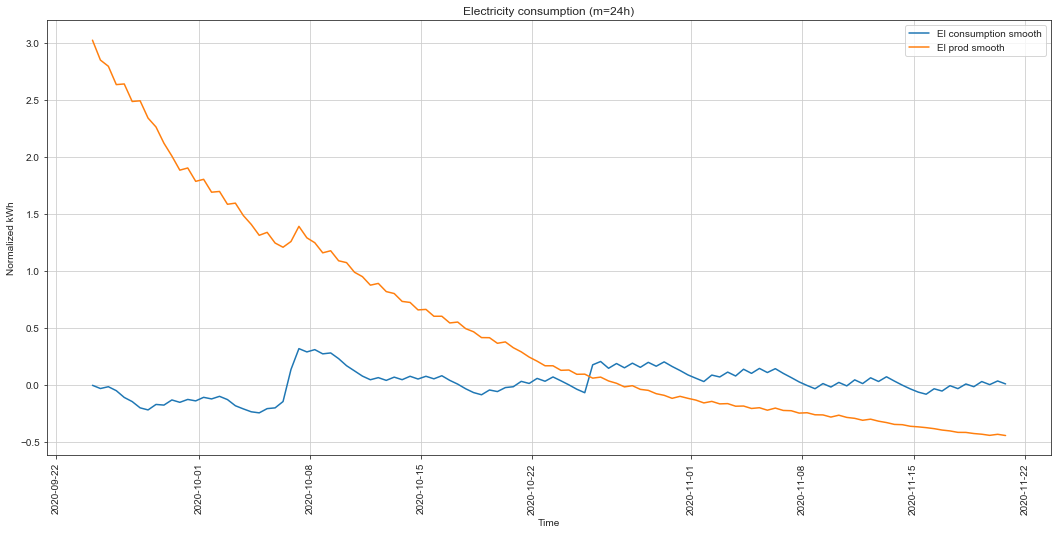

In [243]:
plt.figure(figsize=(18,8))
sns.lineplot(data=en2, x='tm', y=en2_smooth, label = "El consumption smooth")
sns.lineplot(data=prod, x='tm', y=prod_smooth, label = "El prod smooth")
plt.xticks(rotation=90)
plt.title("Electricity consumption (m=24h)")
plt.xlabel("Time")
plt.ylabel("Normalized kWh")
plt.legend()
plt.grid(True)
plt.show()

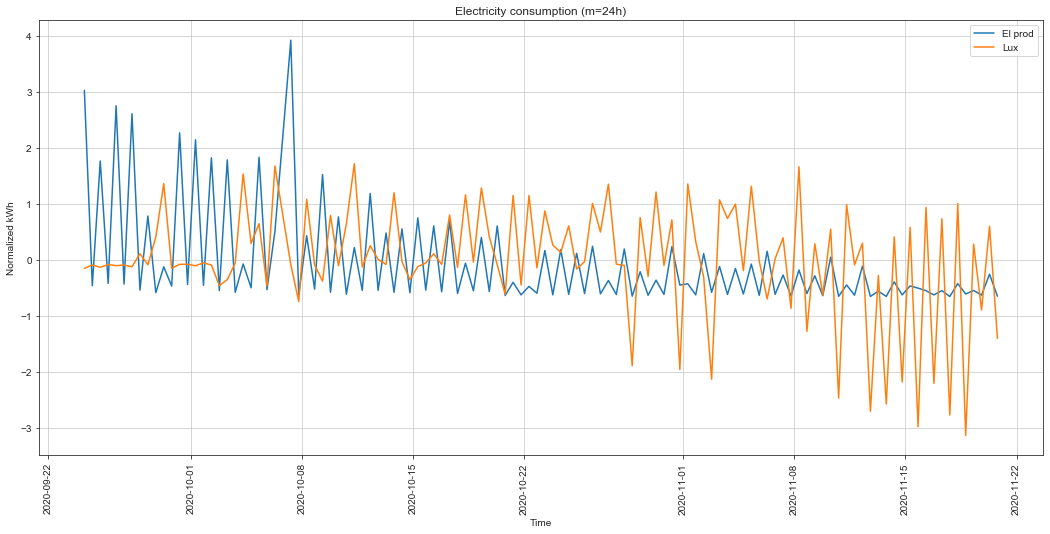

In [245]:
plt.figure(figsize=(18,8))
sns.lineplot(data=prod, x='tm', y='value', label = "El prod")
sns.lineplot(data=lux, x='tm', y='value', label = "Lux")
plt.xticks(rotation=90)
plt.title("Electricity consumption (m=24h)")
plt.xlabel("Time")
plt.ylabel("Normalized kWh")
plt.legend()
plt.grid(True)
plt.show()

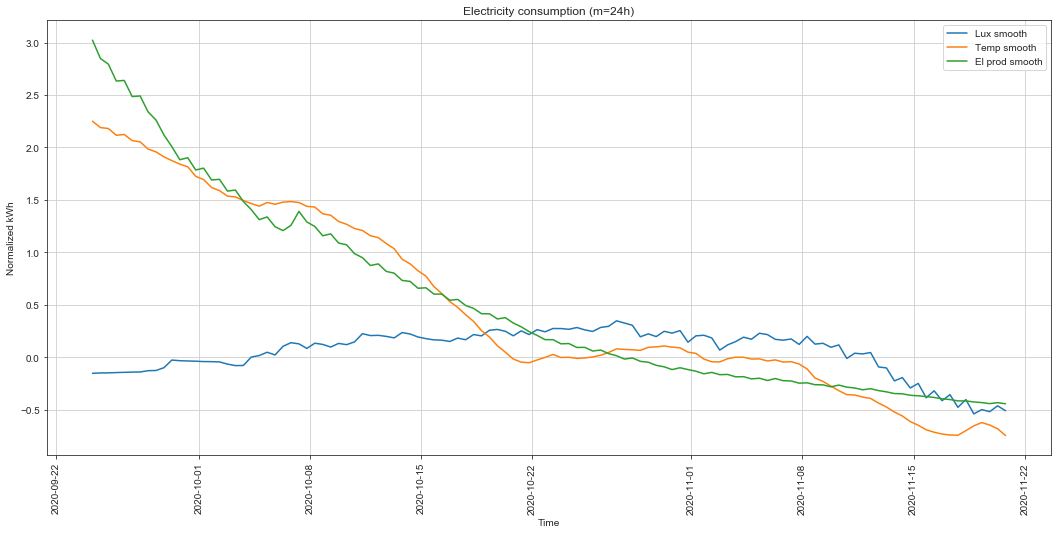

In [246]:
plt.figure(figsize=(18,8))
sns.lineplot(data=lux, x='tm', y=lux_smooth, label = "Lux smooth")
sns.lineplot(data=temp, x='tm', y=temp_smooth, label = "Temp smooth")
sns.lineplot(data=prod, x='tm', y=prod_smooth, label = "El prod smooth")
plt.xticks(rotation=90)
plt.title("Electricity consumption (m=24h)")
plt.xlabel("Time")
plt.ylabel("Normalized kWh")
plt.legend()
plt.grid(True)
plt.show()

# 8. Plots to poster

### 8.1. Light level and temperature

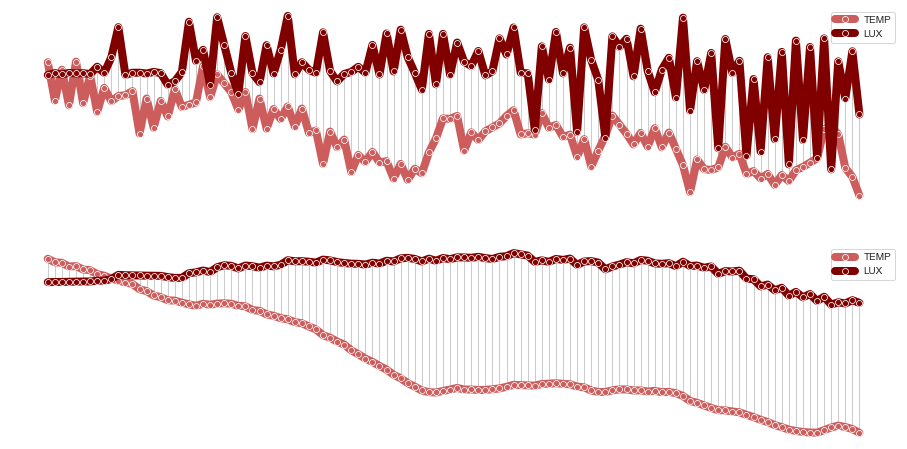

In [193]:
sns.set_style("white")
xshift = 0
yshift = 2
start = 0
interval = 1
start = 0
end = len(temp)
d1 = temp[start:end]
d2 = lux[start:end]

bold = 8
c2 = "maroon"
c1 = "indianred"
#plt.figure(figsize=(18,8))


fig, axes = plt.subplots(2, 1, figsize=(16,8))
fig.axes[0].get_yaxis().set_visible(False)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
fig.axes[0].spines['left'].set_visible(False)
fig.axes[0].spines['bottom'].set_visible(False)
sns.color_palette("icefire", as_cmap=True)
sns.lineplot(ax=axes[0],x=d1["tm"], y=d1["value"]-yshift, color = c1 ,marker='o',linewidth=bold, label = "TEMP")
sns.lineplot(ax=axes[0],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2['value'],  color = c2, marker='o', linewidth=bold, label = "LUX")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[0],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1.iloc[i, 2]-yshift,d2.iloc[i, 2]], color='black', linewidth=0.5)

fig.axes[1].get_yaxis().set_visible(False)
fig.axes[1].get_xaxis().set_visible(False)
fig.axes[1].spines['right'].set_visible(False)
fig.axes[1].spines['top'].set_visible(False)
fig.axes[1].spines['left'].set_visible(False)
fig.axes[1].spines['bottom'].set_visible(False)
sns.lineplot(ax=axes[1],x=d1["tm"], y=np.array(temp_smooth)[start:end]-yshift, color = c1, marker='o',linewidth=bold, label = "TEMP")
sns.lineplot(ax=axes[1],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=lux_smooth[start:end], color = c2, marker='o', linewidth=bold, label = "LUX")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[1],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [temp_smooth[start:end][i]-yshift,lux_smooth[start:end][i]], color='black', linewidth=0.5)


plt.xticks(rotation=90)
#plt.title("...")
#plt.xlabel("...")
#plt.ylabel("...")
plt.legend()
plt.grid(True)
plt.show()

### 8.2. Electricity production

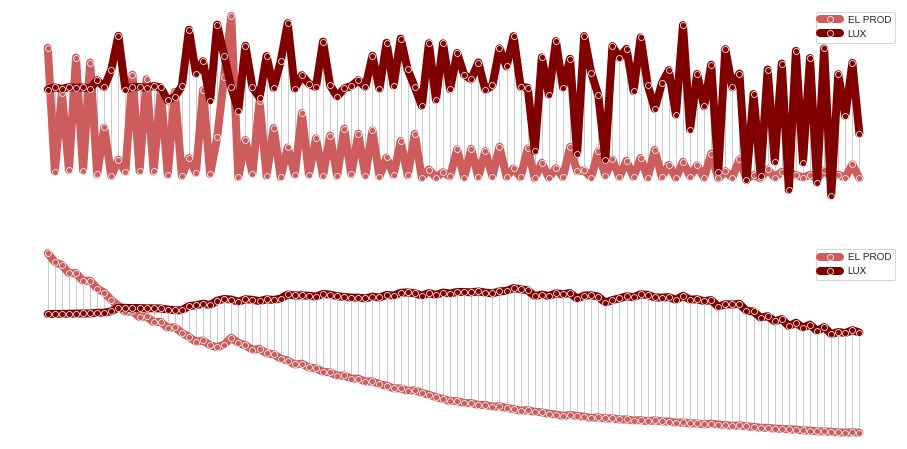

In [213]:
sns.set_style("white")
xshift = 0
yshift = 2
start = 0
interval = 1
start = 0
end = len(temp)
d1 = prod[start:end]
d2 = lux[start:end]

d1s = prod_smooth[start:end]
d2s = lux_smooth[start:end]

bold = 8
c2 = "maroon"
c1 = "indianred"
#plt.figure(figsize=(18,8))


fig, axes = plt.subplots(2, 1, figsize=(16,8))
fig.axes[0].get_yaxis().set_visible(False)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
fig.axes[0].spines['left'].set_visible(False)
fig.axes[0].spines['bottom'].set_visible(False)
sns.color_palette("icefire", as_cmap=True)
sns.lineplot(ax=axes[0],x=d1["tm"], y=d1["value"]-yshift, color = c1 ,marker='o',linewidth=bold, label = "EL PROD")
sns.lineplot(ax=axes[0],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2['value'],  color = c2, marker='o', linewidth=bold, label = "LUX")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[0],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1.iloc[i, 2]-yshift,d2.iloc[i, 2]], color='black', linewidth=0.5)

fig.axes[1].get_yaxis().set_visible(False)
fig.axes[1].get_xaxis().set_visible(False)
fig.axes[1].spines['right'].set_visible(False)
fig.axes[1].spines['top'].set_visible(False)
fig.axes[1].spines['left'].set_visible(False)
fig.axes[1].spines['bottom'].set_visible(False)
sns.lineplot(ax=axes[1],x=d1["tm"], y=np.array(d1s)-yshift, color = c1, marker='o',linewidth=bold, label = "EL PROD")
sns.lineplot(ax=axes[1],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2s, color = c2, marker='o', linewidth=bold, label = "LUX")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[1],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1s[i]-yshift,d2s[i]], color='black', linewidth=0.5)


plt.xticks(rotation=90)
#plt.title("...")
#plt.xlabel("...")
#plt.ylabel("...")
plt.legend()
plt.grid(True)
plt.show()

### 8.3. Heating and temperature

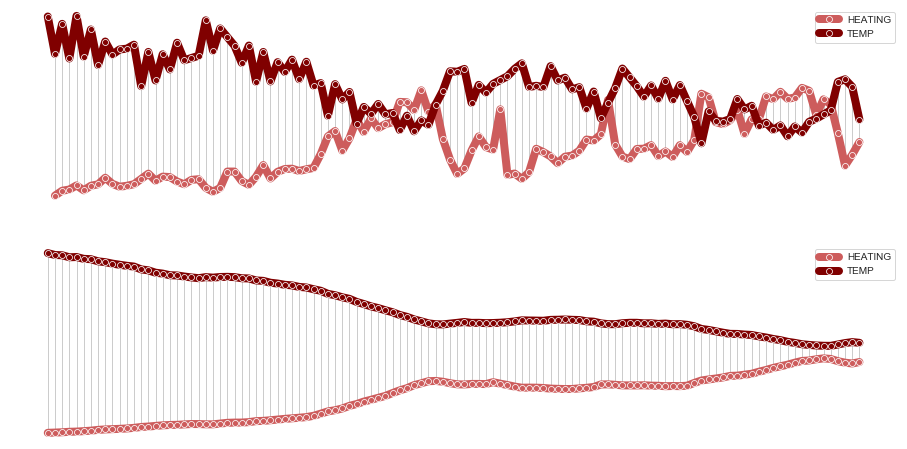

In [212]:
sns.set_style("white")
xshift = 0
yshift = 2
start = 0
interval = 1
start = 0
end = len(heating_smooth)-1
d1 = addedHeating[start:end]
d2 = temp[start:end]

d1s = heating_smooth[start:end]
d2s = temp_smooth[start:end]

bold = 8
c2 = "maroon"
c1 = "indianred"
#plt.figure(figsize=(18,8))


fig, axes = plt.subplots(2, 1, figsize=(16,8))
fig.axes[0].get_yaxis().set_visible(False)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
fig.axes[0].spines['left'].set_visible(False)
fig.axes[0].spines['bottom'].set_visible(False)
sns.color_palette("icefire", as_cmap=True)
sns.lineplot(ax=axes[0],x=d1["tm"], y=d1["value"]-yshift, color = c1 ,marker='o',linewidth=bold, label = "HEATING")
sns.lineplot(ax=axes[0],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2['value'],  color = c2, marker='o', linewidth=bold, label = "TEMP")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[0],x = [d1.iloc[i, 1],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1.iloc[i, 0]-yshift,d2.iloc[i, 2]], color='black', linewidth=0.5)

fig.axes[1].get_yaxis().set_visible(False)
fig.axes[1].get_xaxis().set_visible(False)
fig.axes[1].spines['right'].set_visible(False)
fig.axes[1].spines['top'].set_visible(False)
fig.axes[1].spines['left'].set_visible(False)
fig.axes[1].spines['bottom'].set_visible(False)
sns.lineplot(ax=axes[1],x=d1["tm"], y=np.array(d1s)-yshift, color = c1, marker='o',linewidth=bold, label = "HEATING")
sns.lineplot(ax=axes[1],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2s, color = c2, marker='o', linewidth=bold, label = "TEMP")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[1],x = [d1.iloc[i, 1],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1s[i]-yshift,d2s[i]], color='black', linewidth=0.5)


plt.xticks(rotation=90)
#plt.title("...")
#plt.xlabel("...")
#plt.ylabel("...")
plt.legend()
plt.grid(True)
plt.show()

### 8.4. Electricity consumption and lux or temp

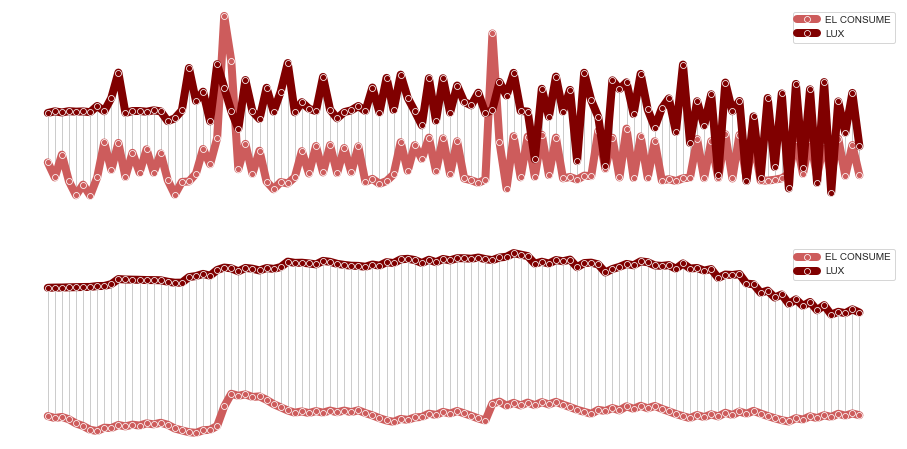

In [217]:
sns.set_style("white")
xshift = 0
yshift = 2
start = 0
interval = 1
start = 0
end = len(temp)
d1 = en2[start:end]
d2 = lux[start:end]

d1s = en2_smooth[start:end]
d2s = lux_smooth[start:end]

bold = 8
c2 = "maroon"
c1 = "indianred"
#plt.figure(figsize=(18,8))


fig, axes = plt.subplots(2, 1, figsize=(16,8))
fig.axes[0].get_yaxis().set_visible(False)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
fig.axes[0].spines['left'].set_visible(False)
fig.axes[0].spines['bottom'].set_visible(False)
sns.color_palette("icefire", as_cmap=True)
sns.lineplot(ax=axes[0],x=d1["tm"], y=d1["value"]-yshift, color = c1 ,marker='o',linewidth=bold, label = "EL CONSUME")
sns.lineplot(ax=axes[0],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2['value'],  color = c2, marker='o', linewidth=bold, label = "LUX")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[0],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1.iloc[i, 2]-yshift,d2.iloc[i, 2]], color='black', linewidth=0.5)

fig.axes[1].get_yaxis().set_visible(False)
fig.axes[1].get_xaxis().set_visible(False)
fig.axes[1].spines['right'].set_visible(False)
fig.axes[1].spines['top'].set_visible(False)
fig.axes[1].spines['left'].set_visible(False)
fig.axes[1].spines['bottom'].set_visible(False)
sns.lineplot(ax=axes[1],x=d1["tm"], y=np.array(d1s)-yshift, color = c1, marker='o',linewidth=bold, label = "EL CONSUME")
sns.lineplot(ax=axes[1],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2s, color = c2, marker='o', linewidth=bold, label = "LUX")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[1],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1s[i]-yshift,d2s[i]], color='black', linewidth=0.5)


plt.xticks(rotation=90)
#plt.title("...")
#plt.xlabel("...")
#plt.ylabel("...")
plt.legend()
plt.grid(True)
plt.show()

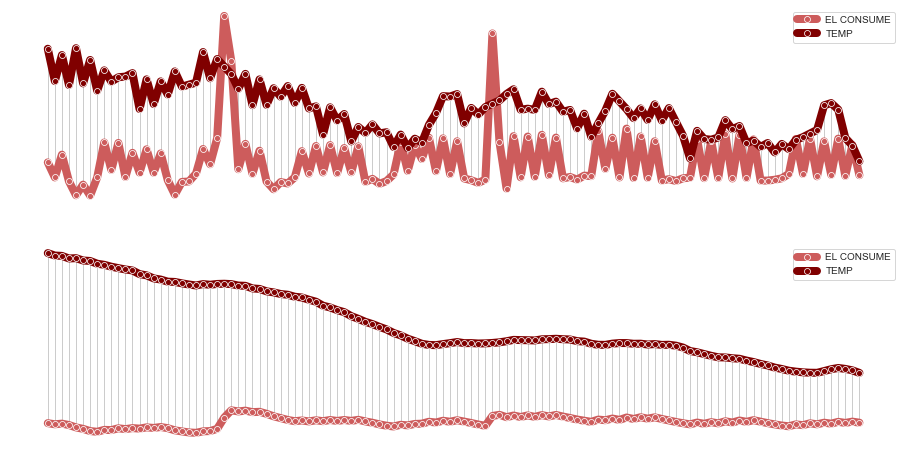

In [218]:
sns.set_style("white")
xshift = 0
yshift = 2
start = 0
interval = 1
start = 0
end = len(temp)
d1 = en2[start:end]
d2 = temp[start:end]

d1s = en2_smooth[start:end]
d2s = temp_smooth[start:end]

bold = 8
c2 = "maroon"
c1 = "indianred"
#plt.figure(figsize=(18,8))


fig, axes = plt.subplots(2, 1, figsize=(16,8))
fig.axes[0].get_yaxis().set_visible(False)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
fig.axes[0].spines['left'].set_visible(False)
fig.axes[0].spines['bottom'].set_visible(False)
sns.color_palette("icefire", as_cmap=True)
sns.lineplot(ax=axes[0],x=d1["tm"], y=d1["value"]-yshift, color = c1 ,marker='o',linewidth=bold, label = "EL CONSUME")
sns.lineplot(ax=axes[0],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2['value'],  color = c2, marker='o', linewidth=bold, label = "TEMP")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[0],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1.iloc[i, 2]-yshift,d2.iloc[i, 2]], color='black', linewidth=0.5)

fig.axes[1].get_yaxis().set_visible(False)
fig.axes[1].get_xaxis().set_visible(False)
fig.axes[1].spines['right'].set_visible(False)
fig.axes[1].spines['top'].set_visible(False)
fig.axes[1].spines['left'].set_visible(False)
fig.axes[1].spines['bottom'].set_visible(False)
sns.lineplot(ax=axes[1],x=d1["tm"], y=np.array(d1s)-yshift, color = c1, marker='o',linewidth=bold, label = "EL CONSUME")
sns.lineplot(ax=axes[1],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2s, color = c2, marker='o', linewidth=bold, label = "TEMP")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[1],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1s[i]-yshift,d2s[i]], color='black', linewidth=0.5)


plt.xticks(rotation=90)
#plt.title("...")
#plt.xlabel("...")
#plt.ylabel("...")
plt.legend()
plt.grid(True)
plt.show()

### 8.5. Electricity consumption and production

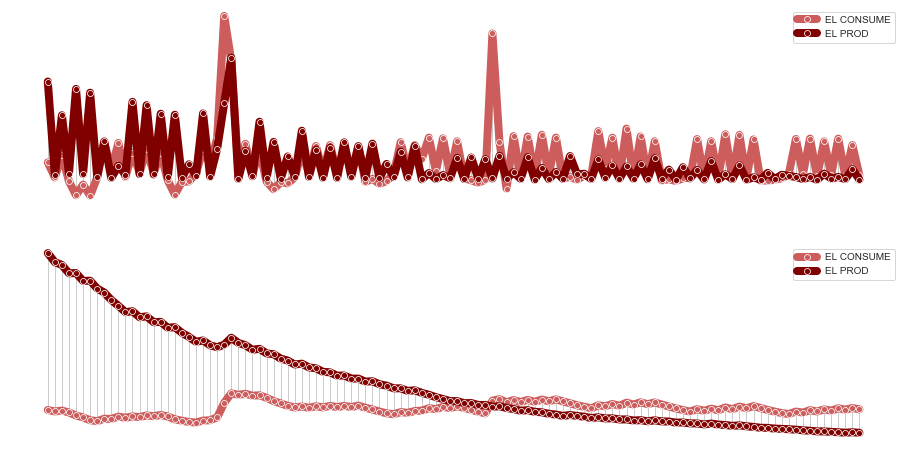

In [220]:
sns.set_style("white")
xshift = 0
yshift = 0
start = 0
interval = 1
start = 0
end = len(temp)
d1 = en2[start:end]
d2 = prod[start:end]

d1s = en2_smooth[start:end]
d2s = prod_smooth[start:end]

bold = 8
c2 = "maroon"
c1 = "indianred"
#plt.figure(figsize=(18,8))


fig, axes = plt.subplots(2, 1, figsize=(16,8))
fig.axes[0].get_yaxis().set_visible(False)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
fig.axes[0].spines['left'].set_visible(False)
fig.axes[0].spines['bottom'].set_visible(False)
sns.color_palette("icefire", as_cmap=True)
sns.lineplot(ax=axes[0],x=d1["tm"], y=d1["value"]-yshift, color = c1 ,marker='o',linewidth=bold, label = "EL CONSUME")
sns.lineplot(ax=axes[0],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2['value'],  color = c2, marker='o', linewidth=bold, label = "EL PROD")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[0],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1.iloc[i, 2]-yshift,d2.iloc[i, 2]], color='black', linewidth=0.5)

fig.axes[1].get_yaxis().set_visible(False)
fig.axes[1].get_xaxis().set_visible(False)
fig.axes[1].spines['right'].set_visible(False)
fig.axes[1].spines['top'].set_visible(False)
fig.axes[1].spines['left'].set_visible(False)
fig.axes[1].spines['bottom'].set_visible(False)
sns.lineplot(ax=axes[1],x=d1["tm"], y=np.array(d1s)-yshift, color = c1, marker='o',linewidth=bold, label = "EL CONSUME")
sns.lineplot(ax=axes[1],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2s, color = c2, marker='o', linewidth=bold, label = "EL PROD")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[1],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1s[i]-yshift,d2s[i]], color='black', linewidth=0.5)


plt.xticks(rotation=90)
#plt.title("...")
#plt.xlabel("...")
#plt.ylabel("...")
plt.legend()
plt.grid(True)
plt.show()

### 8.6. Elecricity production vs temp or lux

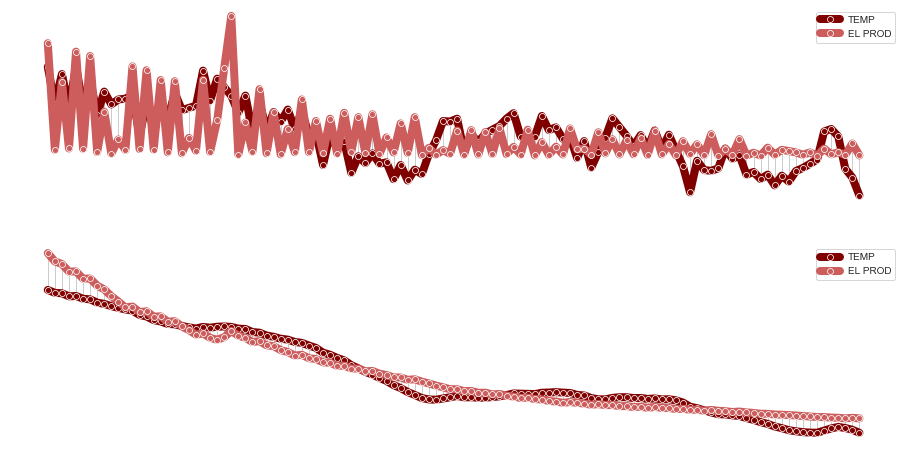

In [249]:
sns.set_style("white")
xshift = 0
yshift = 0
start = 0
interval = 1
start = 0
end = len(temp)
d1 = temp[start:end]
d2 = prod[start:end]

d1s = temp_smooth[start:end]
d2s = prod_smooth[start:end]

bold = 8
c1 = "maroon"
c2 = "indianred"
#plt.figure(figsize=(18,8))


fig, axes = plt.subplots(2, 1, figsize=(16,8))
fig.axes[0].get_yaxis().set_visible(False)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
fig.axes[0].spines['left'].set_visible(False)
fig.axes[0].spines['bottom'].set_visible(False)
sns.color_palette("icefire", as_cmap=True)
sns.lineplot(ax=axes[0],x=d1["tm"], y=d1["value"]-yshift, color = c1 ,marker='o',linewidth=bold, label = "TEMP")
sns.lineplot(ax=axes[0],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2['value'],  color = c2, marker='o', linewidth=bold, label = "EL PROD")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[0],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1.iloc[i, 2]-yshift,d2.iloc[i, 2]], color='black', linewidth=0.5)

fig.axes[1].get_yaxis().set_visible(False)
fig.axes[1].get_xaxis().set_visible(False)
fig.axes[1].spines['right'].set_visible(False)
fig.axes[1].spines['top'].set_visible(False)
fig.axes[1].spines['left'].set_visible(False)
fig.axes[1].spines['bottom'].set_visible(False)
sns.lineplot(ax=axes[1],x=d1["tm"], y=np.array(d1s)-yshift, color = c1, marker='o',linewidth=bold, label = "TEMP")
sns.lineplot(ax=axes[1],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2s, color = c2, marker='o', linewidth=bold, label = "EL PROD")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[1],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1s[i]-yshift,d2s[i]], color='black', linewidth=0.5)


plt.xticks(rotation=90)
#plt.title("...")
#plt.xlabel("...")
#plt.ylabel("...")
plt.legend()
plt.grid(True)
plt.show()

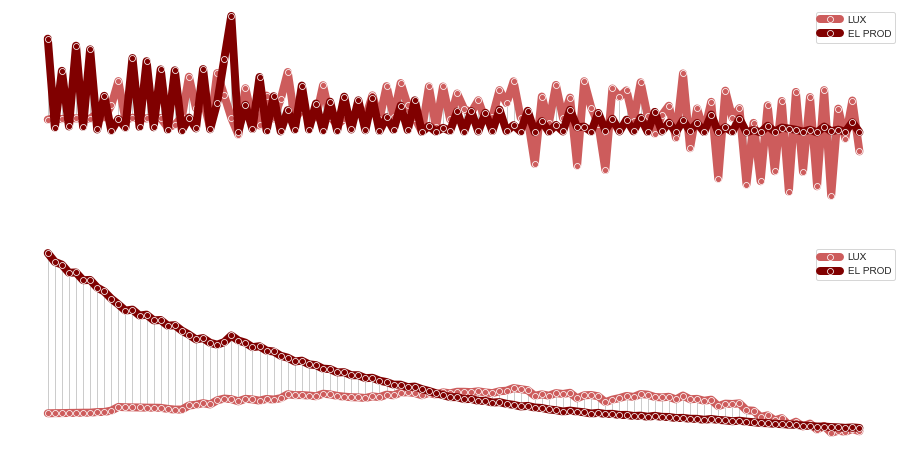

In [250]:
sns.set_style("white")
xshift = 0
yshift = 0
start = 0
interval = 1
start = 0
end = len(temp)
d1 = lux[start:end]
d2 = prod[start:end]

d1s = lux_smooth[start:end]
d2s = prod_smooth[start:end]

bold = 8
c2 = "maroon"
c1 = "indianred"
#plt.figure(figsize=(18,8))


fig, axes = plt.subplots(2, 1, figsize=(16,8))
fig.axes[0].get_yaxis().set_visible(False)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
fig.axes[0].spines['left'].set_visible(False)
fig.axes[0].spines['bottom'].set_visible(False)
sns.color_palette("icefire", as_cmap=True)
sns.lineplot(ax=axes[0],x=d1["tm"], y=d1["value"]-yshift, color = c1 ,marker='o',linewidth=bold, label = "LUX")
sns.lineplot(ax=axes[0],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2['value'],  color = c2, marker='o', linewidth=bold, label = "EL PROD")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[0],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1.iloc[i, 2]-yshift,d2.iloc[i, 2]], color='black', linewidth=0.5)

fig.axes[1].get_yaxis().set_visible(False)
fig.axes[1].get_xaxis().set_visible(False)
fig.axes[1].spines['right'].set_visible(False)
fig.axes[1].spines['top'].set_visible(False)
fig.axes[1].spines['left'].set_visible(False)
fig.axes[1].spines['bottom'].set_visible(False)
sns.lineplot(ax=axes[1],x=d1["tm"], y=np.array(d1s)-yshift, color = c1, marker='o',linewidth=bold, label = "LUX")
sns.lineplot(ax=axes[1],x=pd.DatetimeIndex(d2.tm) + pd.DateOffset(xshift), y=d2s, color = c2, marker='o', linewidth=bold, label = "EL PROD")

for i in range(start,len(d1),interval):
    sns.lineplot(ax=axes[1],x = [d1.iloc[i, 3],d2.iloc[i, 3] + pd.DateOffset(xshift)], y = [d1s[i]-yshift,d2s[i]], color='black', linewidth=0.5)


plt.xticks(rotation=90)
#plt.title("...")
#plt.xlabel("...")
#plt.ylabel("...")
plt.legend()
plt.grid(True)
plt.show()